### Rotating


In [1]:
from moviepy.editor import *
#your_video = "../dataset/good_sync/perry-all-2/P104_2020-12-06_121257717.mp4"
video_sources = ["first_video.mp4", "second_video.mp4","third_video.mp4",
                 "fourth_video.mp4", "sixth_video.mp4",
                 "seventh_video.mp4", "eight_video.mp4", "ninth_video.mp4"]
rotated_video_sources = ["rotated_" + source for source in video_sources]
rotated_video_sources = ['/Users/perrytubul/Desktop/computerscience/year3/Kiois/OurOwnRepo/DATASET_2/subject1/vid.avi']
#for video_source, rotated_source in zip(video_sources, rotated_video_sources):
#    clip = VideoFileClip(video_source)
#    clip = clip.rotate(90)
#    clip.write_videofile(rotated_source)


# Basic engine implementation

#### setup

In [2]:
from facenet_pytorch import MTCNN #for detecting ROI of a moving subject
import torch
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig
import pywt
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet as MCD
from sklearn.preprocessing import StandardScaler
import sys
import pandas as pd


FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"
# 
# since MTCNN is a collection of neural nets and other code, the device must be passed
# in the following way to enable copying of objects when needed internally
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
#video_location = dataset_location + specific_dir + seperator + "lab1.mp4"
#video_location = "rotated.mp4"

[2021-06-05 11:01:08,654] [INFO] [<module>] [18] : Starting ...


## running evm pre-processing

In [3]:
#%run ./evm_preprocessing.ipynb
# video_location = dataset_location + specific_dir + seperator + "out.avi"
#video_location="out2.avi"

#### Detecting the face landmarks and parsing the ROI

In [4]:
def detect_face(frame):
    face_locations_handle_motion = mtcnn.detect(frame)
    face_location = list()
    face_location.append(float(face_locations_handle_motion[0][0][1]))
    face_location.append(float(face_locations_handle_motion[0][0][2]))
    face_location.append(float(face_locations_handle_motion[0][0][3]))
    face_location.append(float(face_locations_handle_motion[0][0][0]))
    face_locations = list()
    face_locations.append(face_location)
    return face_locations

def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    try:
        face_locations = detect_face(frame)
    except Exception as e:
        logging.error("Failure in face detection, error: " + str(e))
        
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (toadd eyebrow top point).
        
        # finding the forehead
        try:
            right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        except:
            return None
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        try:
            left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        except:
            return None
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        try:
            upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        except:
            return None
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        try:
            upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        except:
            return None
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [5]:
red_min_val = 95
green_min_val = 40
blue_min_val = 20
red_green_max_diff = 15
def good_frame(blue, green, red):
    if red <= red_min_val:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= green_min_val:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= blue_min_val:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= red_green_max_diff:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False

    return True

In [6]:
def get_new_frame(vidcap):
    success, next_image = vidcap.read()
    return success, next_image

#### Plotting RGB arrays results

In [7]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [8]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    try:
        channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    except:
        return None
    #channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

#### Getting RGB values from a frame and adding them to arrays

In [9]:
def parse_luminace(red, green, blue):
    luminance_level = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    return luminance_level
def parse_RGB(rois, color_sig):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
    
    for i,r in enumerate(rois):
        try:
            new_red = r.getchannel(0)
        except Exception as e: 
            print(e)
        new_green = r.getchannel(1)
        new_blue = r.getchannel(2)
        b_mean,g_mean,r_mean = np.mean(new_blue),np.mean(new_green),np.mean(new_red)
        luminance_level = parse_luminace(r_mean, g_mean, b_mean)
        if good_frame(b_mean,g_mean,r_mean):
            #color_channels = r.reshape(-1, r.shape[-1])
            #avg_color = color_channels.mean(axis=0)
            color_sig[i].append(g_mean)
    return True, color_sig, luminance_level

In [10]:
def log_video_details(video_source):
    logging.info("\nInformation on video:\t\t\t\t\t\t" + str(video_source) +
                 "\nFPS:\t\t\t\t\t\t" + str(fps) + 
                 "\nRound FPS:\t\t\t\t\t\t" + str(round_fps) + 
                 "\nNumber of frames:\t\t\t\t" + str(number_of_frames) + 
                 "\nNumber of bad frames:\t\t\t\t" + str(bad_frames) + 
                 "\nMax luminanace:\t\t\t\t\t" + str(max_luminance) + 
                 "\nMin luminanace:\t\t\t\t\t" + str(min_luminance) +
                 "\nMax diff of luminanace between adjacent frames:\t" + str(max_diff_luminance_adjacent) +
                 "\nAvg luminanace:\t\t\t\t\t" + str(avg_luminance))

In [11]:
import pandas as pd
def indexes(y, thres=0.3, min_dist=1, thres_abs=False):
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not thres_abs:
        thres = thres * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        # fix if leftmost value in dy is zero
        if zero_plateaus[0][0] == 0:
            dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
            zero_plateaus.pop(0)

        # fix if rightmost value of dy is zero
        if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
            dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
            zero_plateaus.pop(-1)

        # for each chain of zero indexes
        for plateau in zero_plateaus:
            median = np.median(plateau)
            # set leftmost values to leftmost non zero values
            dy[plateau[plateau < median]] = dy[plateau[0] - 1]
            # set rightmost and middle values to rightmost non zero values
            dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0)
        & (np.hstack([0.0, dy]) > 0.0)
        & (np.greater(y, thres))
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks

def print_results(window_sig, window, xlabel, ylabel, change_range, title):
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.subplots()
    while len(window_sig) > len(window):
        window_sig = window_sig[:-1]
    ax.plot(window_sig,window,color ='green')
    if change_range:
        plt.xlim([0, 5])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    plt.show()

import scipy
def find_peaks_with_scipy(window_sig, window, round_fps, hr):
    peaks, _ = scipy.signal.find_peaks(window, distance=round_fps)
    plt.plot(window_sig,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.title("Peaks with scipy")
    plt.show()
    logging.info("Peaks vector with scipy: " + str(peaks) + " num of peaks: " + str(len(peaks)))

def print_peaks(window_sig, window):
    while len(window_sig) > len(window):
        window_sig = window_sig[:-1]
        
    peaks = indexes(window,min_dist=20)
    plt.plot(window_sig,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.title("Peaks with implemented function")
    plt.show()
    logging.info("Peaks vector by implemented function: " + str(window_sig[peaks]) + " num of peaks: " + str(len(window_sig[peaks])))
    #print(window_sig)
    #test_peaks = find_peaks(window_sig)
    #plt.plot(window_sig,window,'-go',markerfacecolor='red',markevery=test_peaks)
    #np.savetxt("time_of_peaks.csv", x[peaks], delimiter=",")
    
def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    
    round_fps = int(round_fps)
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    window_sig = np.arange(window.size/round_fps,step= (1/round_fps))
    
    print_results(window_sig, window, 'X-axis', 'Y-axis', False, "Green signal")

    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False, "Green signal normalized")
    
    g = filter_channel(window,round_fps)
    if g is None:
        return
    from skimage.restoration import denoise_wavelet
    #g = denoise_wavelet(g,wavelet='sym2',wavelet_levels = 4)
    print_peaks(window_sig, g)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False, "")

    f, Pxx_den = sig.periodogram(g, round_fps)
    
    print_results(f, Pxx_den, 'Frequency [Hz]', 'PSD [V**2/Hz]', True, "PSD by Frequency")
    # plt.semilogy(f, Pxx_den)
    # plt.ylim([1e-7, 1e2])
    # plt.xlabel('frequency [Hz]')
    # plt.ylabel('PSD [V**2/Hz]')
    # plt.show()


    max_val = Pxx_den.argmax()
    logging.info("Window " + str(window_id) +
                 ":\nHighest freq:" + str(f[max_val]) + "\nHeart rate: " + str(f[max_val]*60))
    
    find_peaks_with_scipy(window_sig, g,round_fps, f[max_val]*60)

In [12]:
import pywt
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet as MCD
import numpy as np
from sklearn.preprocessing import StandardScaler
from skimage.restoration import denoise_wavelet
from matplotlib import pyplot as plt
import numpy as np
import scipy,itertools
from skimage.restoration import denoise_wavelet
import sys
np.set_printoptions(threshold=sys.maxsize)
def eigenvalue_decomposition(mat):
        """ return (diagonal,orthogonal matrix)
        """
        """
        """
        # eigen_vals, eigen_vectors
        eigen_vals, eigen_vectors = np.linalg.eigh(mat)
        d = np.diag(eigen_vals)
        return d,eigen_vectors

    
def multivariate_video_signal(signal):
    """
    Algorithm 1
    :param signal: is a 2D signal. One dimension the signal from the forehead, and second is from above the upper lip
    :return: multivariate PPG 
    """    
    sig1 = signal[0,:].T
    sig2 = signal[1,:].T
    n = len(sig1)
    wavelet = pywt.Wavelet('sym2') 
    c = pywt.wavedec(np.column_stack((sig1,sig2)),wavelet,level = 4,axis = 0)
    mcd = MCD(random_state = 0).fit(c[-1]).covariance_
    V,D,VT = np.linalg.svd(mcd)

    lst = []
    pca = PCA(1)
    comp = StandardScaler().fit_transform(c[0]) # normalize
    c[0] = comp
    comp = pca.fit_transform(comp)
    comp = np.column_stack((comp,comp))
    lst.append(comp)
    # Basis change 
    for i in range (1,len(c)):
        x_i = np.dot(c[i],V)
        gama_0 = np.sqrt(2*np.log(n)*D[0])
        xi_0 = pywt.threshold(x_i[:,0],value= gama_0,mode='soft')
        gama_1 = np.sqrt(2*np.log(n)*D[1])
        xi_1 = pywt.threshold(x_i[:,1],value= gama_1,mode='soft')
        xi = np.column_stack((xi_0,xi_1))
        xi = xi@VT
        lst.append(xi)
    return pywt.waverec(lst,wavelet,axis = 0)

def mvd(color_sig):
    ppg_hat = multivariate_video_signal(color_sig)
    return ppg_hat


In [13]:
def detect_hr(video_source):
    logging.info("\n=======================\n" + video_source + "\n=======================\n")
    color_sig_array = np.asarray(color_sig)
    plt.figure(figsize=(15,6))
    plt.subplot(2,1,1)
    plt.plot(color_sig_array[0],"green")
    sig_mvd = mvd(color_sig_array) # n X 2
    ppg_hat_zero = filter_channel(sig_mvd[:,0].T,round_fps)
    ppg_hat_one = filter_channel(sig_mvd[:,1].T,round_fps)
    ppg_hat = np.vstack((ppg_hat_zero,ppg_hat_one))
    plt.subplot(2,1,2)
    
    green = ppg_hat[0]
    plt.plot(green,"red")
    #blue = color_sig_array[0][:,2]

    window_start = 0
    window_size = 30
    window_id = 0
    limit = good_frame_number - int(round_fps) * window_size
    while window_start < limit :
        find_hr_in_window(green, window_start, round_fps, window_id, window_size)
        window_start += int(round_fps) * window_size
        window_id += 1
    if window_start < good_frame_number:
        find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

#### Main loop - going over all the frames of the video

[2021-06-05 11:01:09,097] [INFO] [<module>] [8] : Working on video /Users/perrytubul/Desktop/computerscience/year3/Kiois/OurOwnRepo/DATASET_2/subject1/vid.avi
[2021-06-05 11:01:09,105] [INFO] [<module>] [14] : Parsing images ...
[2021-06-05 11:01:09,106] [INFO] [<module>] [29] : Parsing frame 0/1547.0
[2021-06-05 11:01:39,385] [INFO] [<module>] [29] : Parsing frame 100/1547.0
[2021-06-05 11:02:07,826] [INFO] [<module>] [29] : Parsing frame 200/1547.0
[2021-06-05 11:02:36,722] [INFO] [<module>] [29] : Parsing frame 300/1547.0
[2021-06-05 11:03:05,394] [INFO] [<module>] [29] : Parsing frame 400/1547.0
[2021-06-05 11:03:34,358] [INFO] [<module>] [29] : Parsing frame 500/1547.0
[2021-06-05 11:04:03,122] [INFO] [<module>] [29] : Parsing frame 600/1547.0
[2021-06-05 11:04:31,697] [INFO] [<module>] [29] : Parsing frame 700/1547.0
[2021-06-05 11:05:01,056] [INFO] [<module>] [29] : Parsing frame 800/1547.0
[2021-06-05 11:05:31,872] [INFO] [<module>] [29] : Parsing frame 900/1547.0
[2021-06-05 1

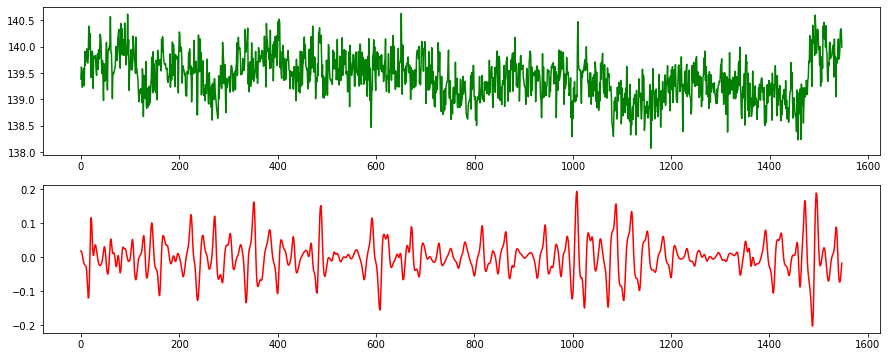

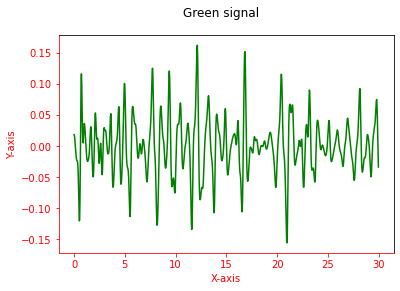

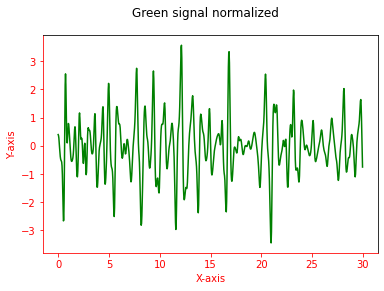

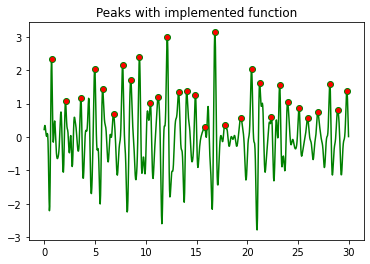

[2021-06-05 11:08:44,159] [INFO] [print_peaks] [107] : Peaks vector by implemented function: [ 0.72413793  2.10344828  3.62068966  4.96551724  5.75862069  6.82758621
  7.72413793  8.51724138  9.37931034 10.44827586 11.20689655 12.13793103
 13.24137931 14.03448276 14.89655172 15.79310345 16.79310345 17.79310345
 19.34482759 20.4137931  21.20689655 22.37931034 23.17241379 23.96551724
 25.10344828 25.93103448 26.93103448 28.13793103 28.89655172 29.79310345] num of peaks: 30


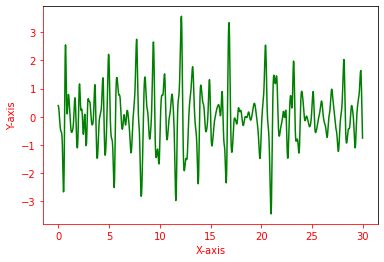

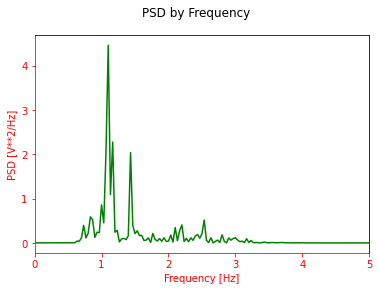

[2021-06-05 11:08:44,403] [INFO] [find_hr_in_window] [147] : Window 0:
Highest freq:1.1
Heart rate: 66.0


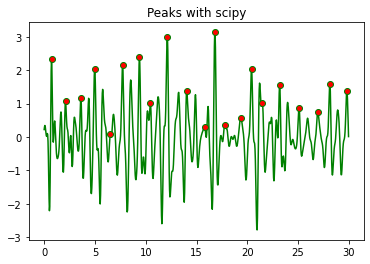

[2021-06-05 11:08:44,534] [INFO] [find_peaks_with_scipy] [97] : Peaks vector with scipy: [ 21  61 105 144 189 224 272 303 352 407 458 487 516 561 592 623 672 728
 781 816 864] num of peaks: 21


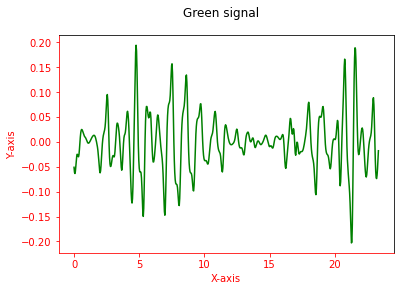

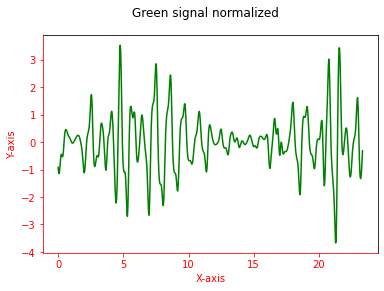

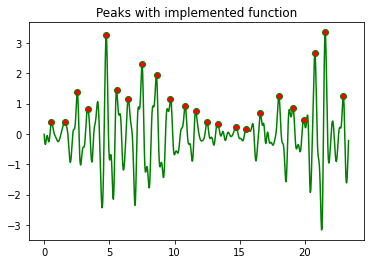

[2021-06-05 11:08:44,933] [INFO] [print_peaks] [107] : Peaks vector by implemented function: [ 0.55172414  1.5862069   2.55172414  3.34482759  4.75862069  5.55172414
  6.44827586  7.51724138  8.62068966  9.68965517 10.82758621 11.62068966
 12.48275862 13.31034483 14.68965517 15.51724138 16.5862069  18.
 19.06896552 19.89655172 20.75862069 21.55172414 22.93103448] num of peaks: 23


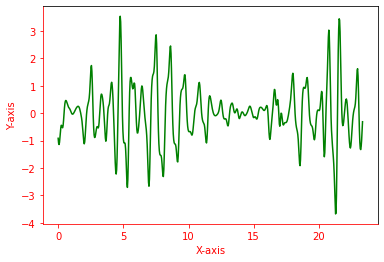

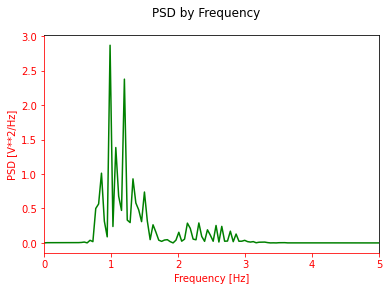

[2021-06-05 11:08:45,187] [INFO] [find_hr_in_window] [147] : Window 1:
Highest freq:0.9837758112094395
Heart rate: 59.02654867256637


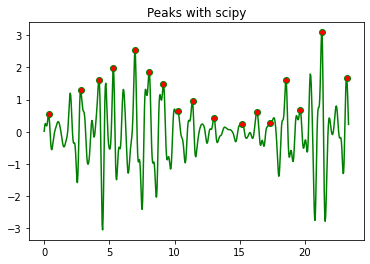

[2021-06-05 11:08:45,315] [INFO] [find_peaks_with_scipy] [97] : Peaks vector with scipy: [ 16  74 138 187 218 250 281 314 362 397 426 481 522 553 586 625 665] num of peaks: 17


In [14]:
# Parsing video:
for video_location in rotated_video_sources:
    color_sig = [[],[]]
    heart_rates = []
    good_frame_number = 0
#     total_frame_number = 180
    total_frame_number = 0
    logging.info("Working on video " + video_location)
    vidcap = cv2.VideoCapture(video_location)
    success, image = vidcap.read()
    fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
    round_fps = np.round(fps)
    number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    logging.info("Parsing images ...")
    skipped_frames = 0
    bad_frames = 0
    max_luminance = 0
    min_luminance = 200
    avg_luminance = 0
    perv_luminance = None
    max_diff_luminance_adjacent = 0

    while success:
#         if skipped_frames < 180:
#             skipped_frames += 1
#             success, image = get_new_frame(vidcap)
#             continue
        if total_frame_number % 100 == 0:
            logging.info("Parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
        rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
        if rois is not None :
            #roi = np.vstack((rois[0], rois[1]))
            try:
                is_good_frame,color_sig, luminance_level = parse_RGB(rois, color_sig)
                if perv_luminance is not None and luminance_level - perv_luminance > max_diff_luminance_adjacent:
                    max_diff_luminance_adjacent = luminance_level - perv_luminance
                if luminance_level > max_luminance:
                    max_luminance = luminance_level
                if luminance_level < min_luminance:
                    min_luminance = luminance_level
                avg_luminance += luminance_level
                perv_luminance = luminance_level
            except Exception as e:
                logging.error("failed to get output from parse_RGB!\nError:" + str(e))
                is_good_frame = False
                bad_frames += 1
            if is_good_frame:
                good_frame_number += 1
                #logging.info("luminance level: " + str(luminance_level))
        if rois is None:
            bad_frames += 1
        total_frame_number += 1
        success, image = get_new_frame(vidcap)
    avg_luminance /= total_frame_number
    log_video_details(video_location)
    detect_hr(video_location)
#     except:
#        logging.warning("Issue in detecting hr in video")



[2021-06-05 11:08:45,322] [INFO] [detect_hr] [2] : 
First Video



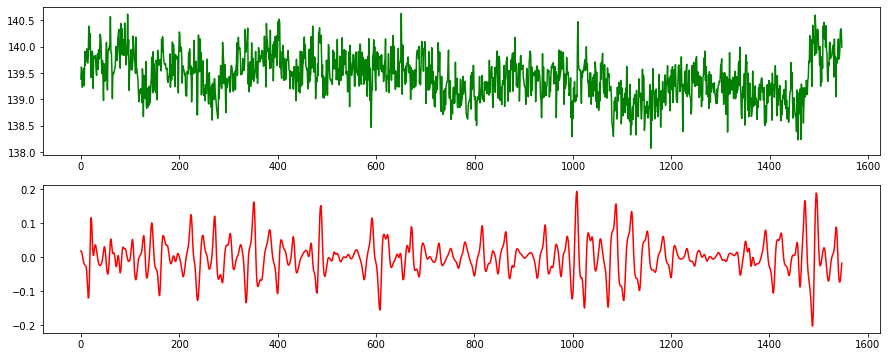

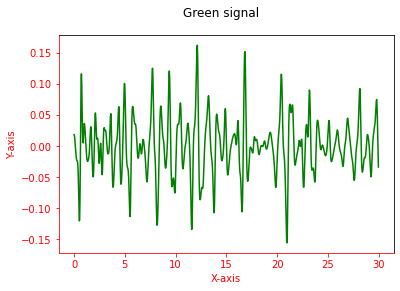

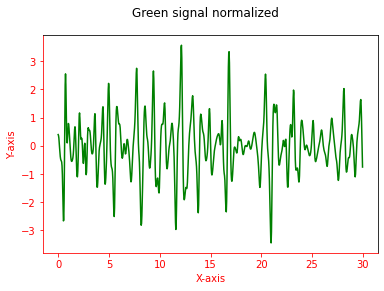

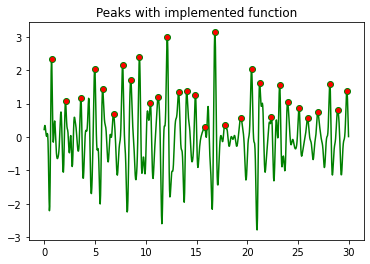

[2021-06-05 11:08:46,442] [INFO] [print_peaks] [107] : Peaks vector by implemented function: [ 0.72413793  2.10344828  3.62068966  4.96551724  5.75862069  6.82758621
  7.72413793  8.51724138  9.37931034 10.44827586 11.20689655 12.13793103
 13.24137931 14.03448276 14.89655172 15.79310345 16.79310345 17.79310345
 19.34482759 20.4137931  21.20689655 22.37931034 23.17241379 23.96551724
 25.10344828 25.93103448 26.93103448 28.13793103 28.89655172 29.79310345] num of peaks: 30


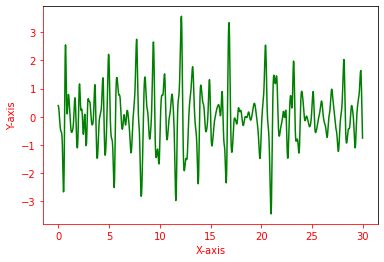

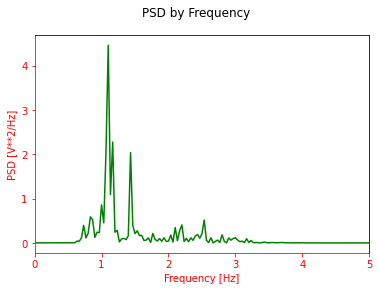

[2021-06-05 11:08:46,721] [INFO] [find_hr_in_window] [147] : Window 0:
Highest freq:1.1
Heart rate: 66.0


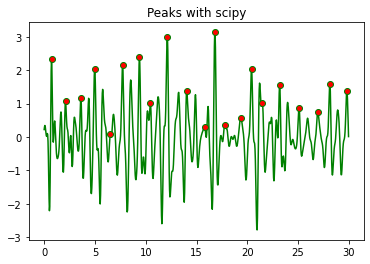

[2021-06-05 11:08:46,870] [INFO] [find_peaks_with_scipy] [97] : Peaks vector with scipy: [ 21  61 105 144 189 224 272 303 352 407 458 487 516 561 592 623 672 728
 781 816 864] num of peaks: 21


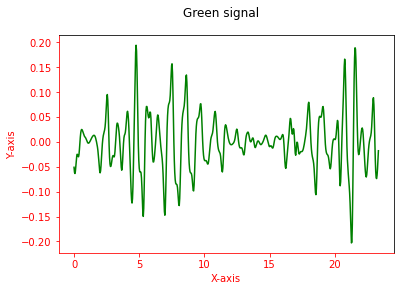

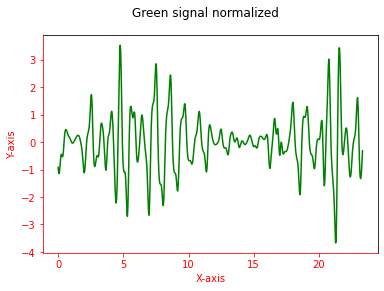

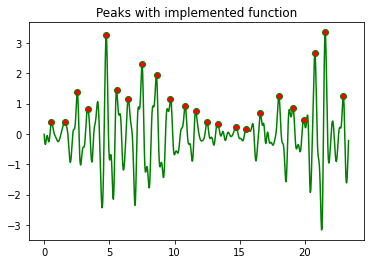

[2021-06-05 11:08:47,293] [INFO] [print_peaks] [107] : Peaks vector by implemented function: [ 0.55172414  1.5862069   2.55172414  3.34482759  4.75862069  5.55172414
  6.44827586  7.51724138  8.62068966  9.68965517 10.82758621 11.62068966
 12.48275862 13.31034483 14.68965517 15.51724138 16.5862069  18.
 19.06896552 19.89655172 20.75862069 21.55172414 22.93103448] num of peaks: 23


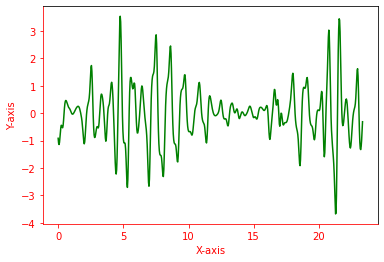

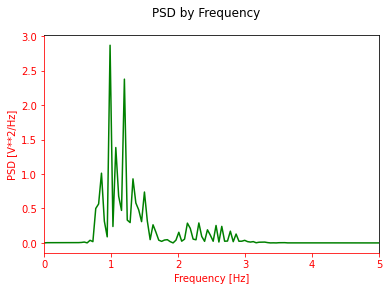

[2021-06-05 11:08:47,558] [INFO] [find_hr_in_window] [147] : Window 1:
Highest freq:0.9837758112094395
Heart rate: 59.02654867256637


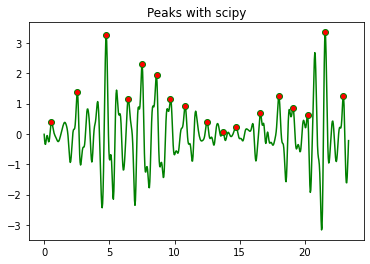

[2021-06-05 11:08:47,677] [INFO] [find_peaks_with_scipy] [97] : Peaks vector with scipy: [ 16  74 138 187 218 250 281 314 362 397 426 481 522 553 586 625 665] num of peaks: 17


In [15]:
detect_hr("First Video")